## K-folder cross-validation with light-gbm
Reference: https://segmentfault.com/a/1190000009101577

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib
from sklearn.metrics import roc_curve, auc
import seaborn as sns

import lightgbm as lgb
import utils

#supression warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load data

In [26]:
data_path = './data/jlr_all_user_processed.xlsx'
df = pd.read_excel(data_path)
df.head(2)

,user_id,follow_count,fans_count,gender,birthday,location,level,registration_time,properties,mileage,...,car_friend_zone,label,car_like,excellent_post_count,all_post_count,regis_year,regis_month,regis_day,date,date_delta
0,oden123,0,0,2,NaT,1,1,2018-03-26,1,4430,...,NaN,True,1,0,0,2018,3,3,2018-03-26,4522
1,生活1934626,2,4,2,NaT,2,1,2012-05-07,1,4270,...,"[{'名称': '汽车之家甘肃论坛车友会', '人数': 672, '创建时间': '201...",True,2,0,0,2012,5,5,2012-05-07,2373


In [27]:
# df.keys(), df.dtypes

### Data choosing  
we choose some features to build the machine learning model

In [28]:
x = df.drop(columns=[
                      'user_id',
#                      'follow_count',
#                      'fans_count', 
#                      'gender', 
                     'birthday',
#                      'location',
#                      'level',
                     'registration_time',
#                      'properties',
#                      'mileage',
                      'post',
                      'cars',
                      'koubei_post',
                      'gas_mileage',
                      'car_friend_zone',
                      'label',
#                      'car_like', 
                     'excellent_post_count',
                     'all_post_count',
                      'regis_year',
                      'regis_month',
                      'regis_day', 
                      'date',
#                      'date_delta'
                     ])
x.head(2)

,follow_count,fans_count,gender,location,level,properties,mileage,car_like,date_delta
0,0,0,2,1,1,1,4430,1,4522
1,2,4,2,2,1,1,4270,2,2373


In [29]:
y = df['label'].astype('uint8')
utils.exploreCat(df, 'label')

In [30]:
# dataset size
_x, _y = np.array(x).astype('int'), np.array(y).astype('int')
_x.shape, _y.shape

((5555, 9), (5555,))

In [31]:
# show positive and negative example
sum(_y==0),sum(_y==1)

(4830, 725)

### Create&Train KFolder dataset, plot ROCs
Reference: https://segmentfault.com/a/1190000009101577

In [32]:
from scipy import interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
import time
import random
random.seed(42)

In [33]:
# Method build light-gbm model
# Reference: 3_2_jlr_classification_11feats.ipynb

import lightgbm as lgb
def lightgbm_model(x_train, x_test, y_train):
    feature_name = list(x.keys())
    categorical_feature = [
#                            'gender',
                           'location',
    #                        'level', 
    #                        'properties', 
                           'car_like',
                         #'regis_year', 'regis_month', 'regis_day',
                          ]
    x_train = lgb.Dataset(x_train.values,
                          y_train.values,
                          feature_name=feature_name,
                         categorical_feature=categorical_feature,)
    params = {
            'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
            'objective': 'binary',
            'metric': ['binary_logloss', 'auc'], 

            'learning_rate': 0.10,

            'num_leaves': 13, #np.random.randint(10,14),
            'max_depth': 9, #np.random.randint(7,10),
            'min_data_in_leaf': 30, # int(2 ** (np.random.rand()*2 + 5)),

            'feature_fraction': 0.8, #np.random.rand()*0.35+0.65,
            'bagging_fraction': 0.9, #np.random.rand()*0.35+0.65,
            'bagging_freq': 1,

            'lambda_l1': 11, #10 ** (np.random.rand() * 4),
            'lambda_l2': 10000, #10 ** (np.random.rand() * 3 + 2),
            'min_gain_to_split': 0.0,
            'min_sum_hessian_in_leaf': 0.1,

            'num_threads': 16,
            'verbose': 0,
            'is_training_metric': 'True'
        }
#     print("Hyper-parameters: ")
#     print(params)
    model = lgb.train(params, x_train, num_boost_round=3000)
    predictions = model.predict(x_test)
    return model, predictions

In [34]:
# Method to train k models and plot their testing results 
def kfolder_plot(train, ytrain, model):
    """
    Args:
    - train: dataframe
    """
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    exe_time = []
    bst_models = {}
    y_preds = {}
    
    colors = cycle(['cyan', 'orange', 'seagreen', 'yellow', 'blue'])
    lw = 2
    
    i = 0
    for(train_idx, test_idx), color in zip(kf.split(train, ytrain), colors):
#         print(train_idx, test_idx)
        x_train, x_test = train.iloc[train_idx], train.iloc[test_idx]
        y_train, y_test = ytrain.iloc[train_idx], ytrain.iloc[test_idx]
#         print(test_idx)
        start = time.time()
        
        bst_model, predictions = model(x_train, x_test, y_train)
        y_preds[i] = predictions
        bst_models[i] = bst_model
        
        end = time.time()
        exe_time.append(round(end-start, 3))
        
        scores.append(roc_auc_score(y_test.astype(float), predictions))
        fpr, tpr, thresholds = roc_curve(y_test, predictions)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
#         print("roc_auc: ", roc_auc)
        plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area=%0.2f)'%(i, roc_auc))
        i += 1
#         print(classification_report(y_test, predictions>=0.5))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='ROC baseline')
    mean_tpr /= kf.get_n_splits(train, ytrain)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='r', linestyle='--', label='Mean ROC(are a = %0.2f)'%mean_auc, lw=lw)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC KFolder')
    plt.legend(loc='lower right')
    plt.show()
    
    print('mean scores: ', np.mean(scores))
    print('mean model process time: ', np.mean(exe_time))
    return scores, np.mean(scores), np.mean(exe_time), bst_models, y_preds

##### Train the 5 models and plot the testing result(ROC) of k models

In [35]:
dct_scores = {}
mean_score = {}
mean_time = {}
models = {}
y_preds = {}

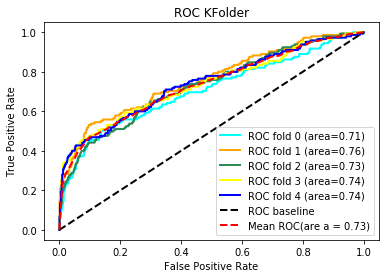

mean scores:  0.7333861640608268
mean model process time:  11.527


In [36]:
import time
dct_scores['lgbm'], mean_score['lgbm'], mean_time['lgbm'], bst_models, y_preds = kfolder_plot(x, y, lightgbm_model)

In [37]:
train_idxs = []
test_idxs = []
kf = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
for (train_idx, test_idx) in kf.split(x, y):
    train_idxs.append(train_idx)
    test_idxs.append(test_idx)
#     print(test_idx)

#### Plot feature importance of 5 models

[   2   10   23 ... 5551 5552 5553]
num_y_pred_1:num_y_pred_0 =42:1069 
             precision    recall  f1-score   support

          0       0.89      0.99      0.94       966
          1       0.67      0.19      0.30       145

avg / total       0.86      0.88      0.85      1111

roc_auc:  0.705632897836796


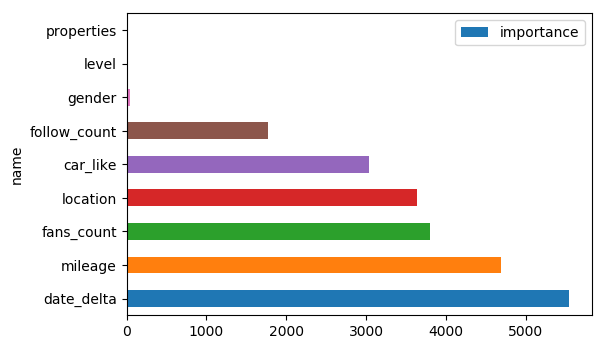

[   6    7    9 ... 5522 5537 5554]
num_y_pred_1:num_y_pred_0 =36:1075 
             precision    recall  f1-score   support

          0       0.89      0.99      0.94       966
          1       0.86      0.21      0.34       145

avg / total       0.89      0.89      0.86      1111

roc_auc:  0.7570643249803669


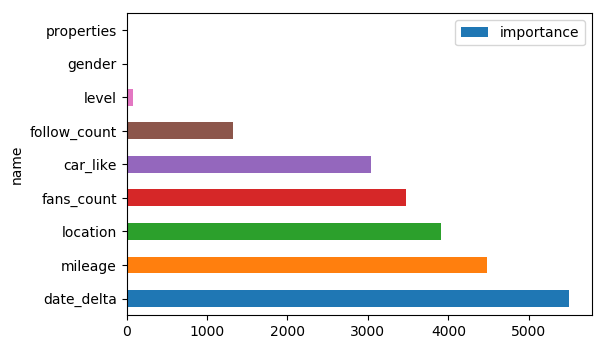

[   0    3    5 ... 5544 5545 5550]
num_y_pred_1:num_y_pred_0 =22:1089 
             precision    recall  f1-score   support

          0       0.88      0.99      0.94       966
          1       0.77      0.12      0.20       145

avg / total       0.87      0.88      0.84      1111

roc_auc:  0.7286820875276647


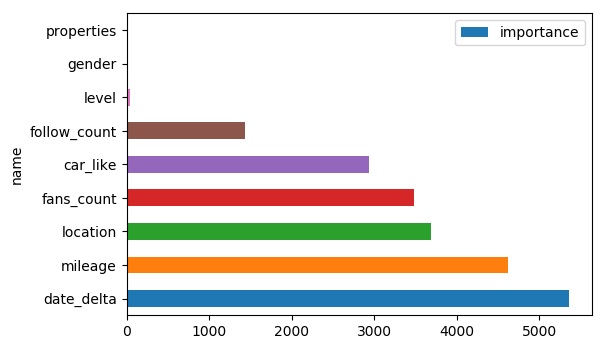

[   8   36   37 ... 5542 5546 5548]
num_y_pred_1:num_y_pred_0 =41:1070 
             precision    recall  f1-score   support

          0       0.90      0.99      0.94       966
          1       0.83      0.23      0.37       145

avg / total       0.89      0.89      0.87      1111

roc_auc:  0.7359427429142572


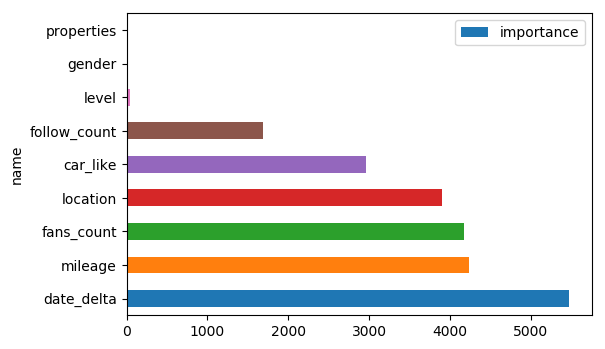

[   1    4   13 ... 5541 5547 5549]
num_y_pred_1:num_y_pred_0 =43:1068 
             precision    recall  f1-score   support

          0       0.90      0.99      0.94       966
          1       0.79      0.23      0.36       145

avg / total       0.88      0.89      0.87      1111

roc_auc:  0.7396087670450489


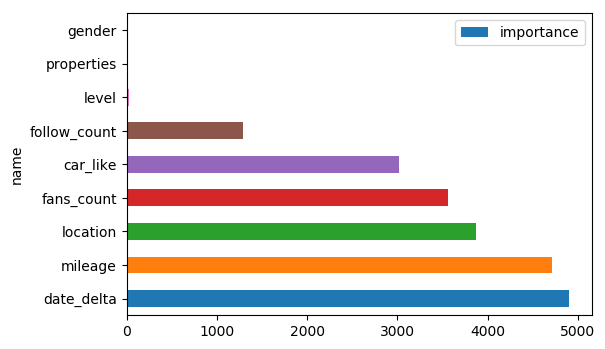

In [38]:
for i in range(5):
    gbm = bst_models[i]
    x_test = x.iloc[test_idxs[i]]
    y_test = y.iloc[test_idxs[i]]
    print(test_idxs[i])

    # y_pred = gbm.predict(x_test)
    y_pred = y_preds[i]

    # y_pred = y_pred >= 0.5
    # print(y_pred[:10])

    from sklearn.metrics import accuracy_score, confusion_matrix
    # print(accuracy_score(y_test, y_pred))
    print("num_y_pred_1:num_y_pred_0 ={}:{} ".format(sum(y_pred>=0.5), sum(y_pred<0.5)))
    _y_pred = y_pred >= 0.5
    # print(confusion_matrix(y_true=y_test, y_pred=y_pred))
    print(classification_report(y_true=y_test, y_pred=_y_pred))

    # AUC 
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print("roc_auc: ",roc_auc)

    feature_importance = pd.DataFrame({'name':gbm.feature_name(), 'importance':gbm.feature_importance()}).sort_values(by='importance', ascending=False)
    feature_importance.to_csv('./feat_importance.csv', index=False)
    # fig = matplotlib.pyplot.gcf()
    # fig.set_size_inches(15, 5)
    plt.rcParams['savefig.dpi'] = 50 #图片像素
    plt.rcParams['figure.dpi'] = 100 #分辨率
    feature_importance.plot(x='name', y='importance',kind='barh')
    # plt.savefig('plot123_2.png', dpi=300) 
    plt.show()